![Erudio](img/Erudio-logo.png)

In [1]:
from src.setup import *

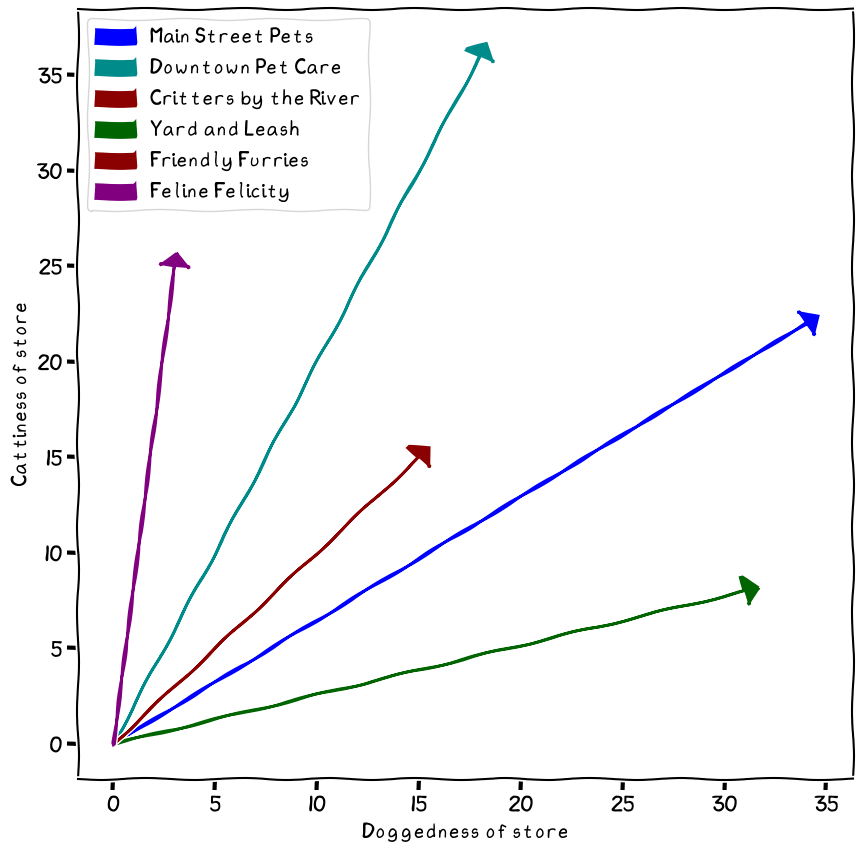

In [2]:
import matplotlib.pyplot as plt

with plt.xkcd():
    plt.figure(figsize=(10,10))
    plt.arrow(0, 0, 34, 22, head_width=1.5, head_length=0.7, fc='blue', ec='blue', linewidth=2, label="Main Street Pets")
    plt.arrow(0, 0, 18, 36, head_width=1.5, head_length=0.7, fc='darkcyan', ec='darkcyan', linewidth=2, label="Downtown Pet Care")
    plt.arrow(0, 0, 31, 8, head_width=1.5, head_length=0.7, fc='darkred', ec='darkred', linewidth=2, label="Critters by the River")
    plt.arrow(0, 0, 31, 8, head_width=1.5, head_length=0.7, fc='darkgreen', ec='darkgreen', linewidth=2, label="Yard and Leash")
    plt.arrow(0, 0, 15, 15, head_width=1.5, head_length=0.7, fc="darkred", ec='darkred', linewidth=2, label="Friendly Furries")
    plt.arrow(0, 0, 3, 25, head_width=1.5, head_length=0.7, fc="purple", ec='purple', linewidth=2, label="Feline Felicity")

    plt.legend(loc=2)
    plt.xlabel("Doggedness of store")
    plt.ylabel("Cattiness of store")
    plt.savefig('img/dog_cat.png')

### Field Splitting

In chapter 5 (*Data Quality*) we exhibited a function `apache_log_to_df()` that did some custom field splitting in a log file, to produce extracted features that were more relevant to the purpose at hand.  Refer back there for a similar example to the one we present here (used there for with a different emphasis than here).  As another example, we will parse parts of a `/var/log/dmesg` log on my system.  This file is used to record some kernel activities, mostly loading device drivers during system boot.  There are a number of other log files that serve related, and somewhat overlapping, purposes.  For this book, we are not concerned with Linux kernel and file layout design, but simply with a data file that has some contours of interest.<sup><i>dmesg</i></sup>

<div id="dmesg" 
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>dmesg</i><br/>
Even if you maintain or debug Linux systems, you will rarely look directly at <code>/var/log/dmesg</code> itself.  Instead, you will usually use the <code>dmesg</code> command that will read, format, and filter a number of system log files, including this one, presenting specific elements of kernel events of interest to users based on those log files. This section shows how to do a cruder version of something akin to what that well-tested utility program does.    
</div>

A variety of information is logged to `/var/log/dmesg`, most of which we will ignore for the purpose of this section.  What will interest us is only those lines that have something to do with allocating memory.  The format of this file—as with other system log files—is somewhat irregular between different events, with different information occurring in different fields depending on the kind of event.  That said, some regularities do exist.  Components of a log line are separated by colons, and the first field is consistently a time measurement since boot (often just a few microseconds between events).

A few sample rows look like this.  We use a few heuristics even in this display, and will use others below.  The memory allocation lines always contain the a consistent substring; we also present a random subset of lines with a determistic random seed (we can use the file itself as the source of the seed).  For presentation purposes, we use `fmt` and `sed` to wrap the displayed lines and indent the continuation in the output.

In [3]:
%%bash
zcat data/dmesg.3.gz | 
    grep '\[mem' | 
    shuf -n 10 --random-source=data/dmesg.3.gz |
    fmt -s -w70 | 
    sed -e 's/^[^[]/   … /'

[    0.628891] kernel: pci 0000:39:00.1: reg 0x20: [mem
   … x86200000-0x86203fff 64bit]
[    0.368469] kernel: PCI: MMCONFIG for domain 0000 [bus 00-ff]
   … t [mem 0xe0000000-0xefffffff] (base 0xe0000000)
[    0.700407] kernel: pci_bus 0000:02: resource 1 [mem
   … x70000000-0x860fffff]
[    0.000000] kernel: BIOS-e820: [mem
   … x000000005f59f000-0x000000005fc8efff] ACPI NVS
[    0.700248] kernel: pci 0000:39:00.0: can't claim BAR 6 [mem
   … xffff0000-0xffffffff pref]: no compatible bridge window
[    0.000000] kernel: reserve setup_data: [mem
   … x000000005f59f000-0x000000005fc8efff] ACPI NVS
[    0.667219] kernel: e820: reserve RAM buffer [mem
   … x0009f000-0x0009ffff]
[    0.000000] kernel: BIOS-e820: [mem
   … x000000000009f000-0x00000000000fffff] reserved
[    0.177207] kernel: PM: Registered nosave memory: [mem
   … x5fd10000-0x6d7fffff]
[    0.620717] kernel: pci 0000:00:1f.3: reg 0x20: [mem
   … x6023000000-0x60230fffff 64bit]


What do we have in this log file, exactly? The first "field" is the value between the first square brackets, representing a number of seconds since boot that the event occurred.  The total time for all events is just under a minute, although the memory allocations occur in the first second.  We will stipulate that this boot-up of the machine began at '2020-02-05T23:47:00' as a means of attaching an exact timestamp to each record (this is approximately true for the file used).

Prior to the first colon, we always see the word 'kernel' for these log lines.  The value 'systemd' also occurs rarely for lines not concerned with memory allocations.  We can discard that substring that does not distinguish records for this purpose.  A bit further along is the part of the line that concerns memory allocation.  It is always another term in square brackets, taking the form of the substring 'mem' followed by a space, then by a range of hexadecimal addresses.  Sometimes, but not always, the address range is accompanied by a pointer-size annotation within the brackets.  On my system this is always 64-bit, but let us contemplate in our parsing that we would like to parse similar files from 32-bit systems (or that have device drivers of differing bit-width).

There are a few more interesting parts, but where they occur is not completely regular.  Following 'kernel:' on each line is what me might call the "component" of interest, such as 'pci_bus' or 'BIOS'.  Sometimes that term is space separated from additional details about it, but we will discard that annotation for our purposes.  Sometimes, but not always, after the memory range in brackets and a space, we have what we could call a "status" that takes values such as 'reserved', 'usable', and 'ACPI NVS'.  These are worth keeping as well.

Let us summarize what we have identified as interesting:

* A timestamp for the event
* A starting memory address
* An ending memory address
* A bit-width of the address scheme (optional)
* Component
* Status (optional)

There are a few approaches we might take to reading, massaging, and data typing this data set.  We could read it in as a Pandas DataFrame, using the colons as separators (or better, colon-space since colons alone are used without spaces in annotations).  However, the number of colons is not uniform, so we would certainly need to create filters to look at the rows where memory addresses wind up in column 3 versus column 4.  A style of utilizing the `.str` accessor on Pandas string columns to split, cast, and otherwise manipulate values is certainly possible.  However, while probably slower, writing this logic as sequential Python that loops over lines is less cryptic.

As a start, we will use a `dataclass`, which is a helpful new addition to Python 3.7.  This is similar to a structure in some other languages, with named fields and some helpful default behaviors.  We may convert it to a tuple or a dict, among other capabilities, and it has a friendly representation.  The definition of a dataclass also carries suggested types as annotations; they are not enforced, as we can see even in the provided default None for intended string fields.

In [4]:
@dataclass
class DmesgLine:
    timestamp: datetime = datetime(2020, 2, 5, 23, 47, 0)
    mem_start: int = 0
    mem_end: int = 0
    component: str = None
    pointer_size: str = None
    status: str = None
        
asdict(DmesgLine())

{'timestamp': datetime.datetime(2020, 2, 5, 23, 47),
 'mem_start': 0,
 'mem_end': 0,
 'component': None,
 'pointer_size': None,
 'status': None}

With our record structure prepared, it is simply a matter of looping through each line and parsing out the relevant data using some heuristics and conditional branches.  We will cast the strings we parse to a variety of data types.  This code is more detailed than most presented in this book, and some is potentially fragile if different kinds of messages might occur in other logs.  However, something like this ad hoc style—perhaps sprinkled with `assert` statements about the expected formats—is what you will often need to write to deal with semi-structured string fields.

In [5]:
def memory_allocations(dmesg_fname):
    # Collect records in a list to convert to DataFrame later
    records = []

    for line in gzip.open(dmesg_fname):
        # work with strings not bytes
        line = line.decode('utf-8')
        
        # only lines with memory allocations of interest
        if '[mem' not in line:
            continue
            
        # Create a record
        record = DmesgLine()

        # first pull out only the timedelta, retain the rest
        delta, rest = line.split(']', 1)

        # discard initial '[' and find sec/μs
        seconds, μs = [int(v) for v in delta[1:].split('.')]
        record.timestamp += timedelta(seconds=seconds, 
                                      microseconds=μs)

        # find the memory range
        prefix, rest = rest.split('[mem ')
        mem, rest = rest.split(']')
        if ' ' in mem:
            mem_range, pointer_size = mem.split(' ', 1)
        else:
            mem_range, pointer_size = mem, None
        start, end = [int(s, 16) for s in mem_range.split('-')]
        record.mem_start = start
        record.mem_end = end
        record.pointer_size = pointer_size

        # status take a few different forms, only some of which are useful
        if '(' in rest or ':' in rest:
            # These are non-status parts
            status = None
        else:
            status = rest.strip() 
            # ad hoc simplification of message
            if status == 'has been reserved':
                status = "reserved"
            elif ' in E820' in status:
                status = status.replace(' in E820', '')
            elif '==> ' in status:
                status = status.split('==> ')[1]
        # empty string marked as explicit missing
        record.status = status or None

        # component is a bit futzy; trial-and-error for steps
        component = prefix.replace('kernel: ', '').strip()
        if component.startswith('e820: '):
            component = component.replace('e820: ', '')
        if component.startswith('reserve '):
            component = component.replace('reserve ', '').strip(':')
        else:
            component = component.split(':')[0].strip()
            if ' ' in component:
                component = component.split(' ')[0]
        # Sometimes e.g. either PCI or pci
        component = component.upper()
        # Just 'BIOS' rather than 'BIOS-E820' for this system
        record.component = component.replace('-E820', '')
        records.append(astuple(record))
        
    return pd.DataFrame(records, columns=asdict(DmesgLine()))

Using these various heuristics to pull each field we care about from the overall string, we get a suitable function to read in memory allocations from a dmesg log. This function is of realistic and common complexity, but the point here is more to get the gestalt of splitting fields, looking for special strings that indicate one type of format versus the other, and similar ad hoc logic.

In [6]:
dmesg = memory_allocations('data/dmesg.3.gz')
dmesg.sample(8, random_state=6)

,timestamp,mem_start,mem_end,component,pointer_size,status
72,2020-02-05 23:47:00.177210,4261482496,4275109887,PM,None,None
53,2020-02-05 23:47:00.014434,1607528448,1607532543,NODE,None,None
94,2020-02-05 23:47:00.608428,412905127936,412905144319,PCI,64bit,None
89,2020-02-05 23:47:00.601867,274877906944,275146342399,PCI,64bit pref,None
19,2020-02-05 23:47:00.000000,1107619864,1107675223,UPDATE,None,usable
11,2020-02-05 23:47:00.000000,4261412864,4261482495,BIOS,None,reserved
135,2020-02-05 23:47:00.690893,4251779072,4251844607,SYSTEM,None,reserved
92,2020-02-05 23:47:00.606717,412905144320,412905152511,PCI,64bit,None


The cleaned up status messages we retained look like this.

In [7]:
dmesg.status.value_counts()

status
reserved                     34
usable                       19
could not be reserved         6
ACPI NVS                      2
ACPI data                     2
available for PCI devices     1
Name: count, dtype: int64

It might be fun to see what types of allocations occur per component, and in what regions of memory.  This could perhaps give us some insight into the load process of the Linux kernel, for example.  All of the events listed occur within a matter of microseconds, so it seems more interesting to label the x-axis  by the component rather than the time.

In [8]:
(dmesg.iloc[15:60]  # The first several are all BIOS
     .set_index("component")
     .mem_start
     .plot(kind='bar', logy=True, figsize=(12, 3)));

At the scale of the graph, we can see that some allocations occur at low memory addresses, others around 1GiB, and most others above 4GiB.  It is difficult to see more precisely what addresses specific allocations occur at.  A textual presentation makes it more clear that these are different addresses per line.

This specific example dug into the weeds of parsing one particular string format. However, every specific example that you will care about will be similarly idiosyncratic, and involve slightly different equally ad hoc steps.  It is *possible* that you will encounter a format that has a formal and specified grammar.  If so, use one of the many excellent parsing libraries available for Python, R, and other programming languages.  It is, however, *very unlikely* that you will be that lucky.  Most real strings are generated informally, with patterns that are full of exceptions and special cases, and yet indeed contain information you care about.